In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("../Davidson-Original/data/labeled_data.csv")

In [4]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
# Extracting only the hate tweets

hate_tweets = df.loc[df['class'] == 0, ['tweet', 'class']].values.tolist()
# count of labels of hate_tweets (2nd value in each tuple)
count = 0
for tweet, label in hate_tweets:
    if label == 0:
        count += 1
print(count)

1430


In [ ]:
import time
import cohere
import sys
from tqdm import tqdm

# Initialize Cohere client
co = cohere.Client('KNUTSo91Gn1BuorPehyRah5oyAG4jgWTkPsleIzu')

prompt = """
## Instructions
Below is a tweet. Pharaphase it and generate a new tweet that has the same sentiment. Note that your output should only be the tweet. Don't generate anything else. Just the tweet.

## Input Tweet
{tweet}

## Output Tweet:
"""

# List to store original and paraphrased tweets
original_tweets = []
paraphrased_tweets = []
classes = []

# List to store tweets with errors
tweets_with_errors = []

# Retry function for handling API call limit
def retry_generate(tweet, label):
    try:
        response = co.generate(
            model='command-nightly',
            prompt=prompt.format(tweet=tweet),
            max_tokens=300,
            temperature=0.7,
            k=0,
            p=0.75,
            stop_sequences=[],
            return_likelihoods='NONE'
        )
        return response.generations[0].text.strip()
    except Exception as e:
        if 'blocked input: please adjust your prompt and try again, as it may be a potential violation' in str(e).lower():
            tweets_with_errors.append((tweet, e))
            print("Length of tweets_with_errors: ", len(tweets_with_errors))
            print("=======================================================")
            return None
        elif 'blocked output: please adjust your prompt and try again, as this generation may be a potential violation' in str(e).lower():
            tweets_with_errors.append((tweet, e))
            print("Length of tweets_with_errors: ", len(tweets_with_errors))
            print("=======================================================")
            return None
        elif 'you are using a trial key, which is limited to 5 api calls' in str(e).lower():
            # Wait for 5 mins and retry
            print("Waiting for 1 min...")
            time.sleep(61)
            print("Retrying...")
            return retry_generate(tweet, label)
        else:
            print("NEW ERROR: ", e)
            tweets_with_errors.append((tweet, e))
            print("=======================================================")
            return None

# Generate extended text for each tweet
# for tweet, label in hate_tweets:
for tweet, label in tqdm(hate_tweets, desc="Processing Tweets"):
    print("ORIGINAL: ", tweet)
    paraphrased_tweet = retry_generate(tweet, label)
    if paraphrased_tweet:
        print("PARAPHRASED: ", paraphrased_tweet)
        print("=======================================================")
        # Store original tweet, paraphrased tweet, and class label
        original_tweets.append(tweet)
        paraphrased_tweets.append(paraphrased_tweet)
        classes.append(label)

# Create DataFrame with original and paraphrased tweets
synthetic_df = pd.DataFrame({
    'original_tweet': original_tweets,
    'paraphrased_tweet': paraphrased_tweets,
    'class': classes
})

# Save the DataFrame to a CSV file
synthetic_df.to_csv('synthetic_hate_speech_cohere.csv', index=False)

# Create DataFrame with tweets containing errors
tweets_with_errors_df = pd.DataFrame({'tweet_and_error': tweets_with_errors}, columns=['tweet_and_error'])

# Split the 'tweet_and_error' column into 'tweet' and 'error' columns
tweets_with_errors_df[['tweet', 'error']] = pd.DataFrame(tweets_with_errors_df['tweet_and_error'].tolist(), index=tweets_with_errors_df.index)

# Drop the original 'tweet_and_error' column
tweets_with_errors_df.drop(columns=['tweet_and_error'], inplace=True)

# Save the DataFrame with tweets containing errors to a CSV file
tweets_with_errors_df.to_csv('tweets_with_errors.csv', index=False)



# Value for max_length

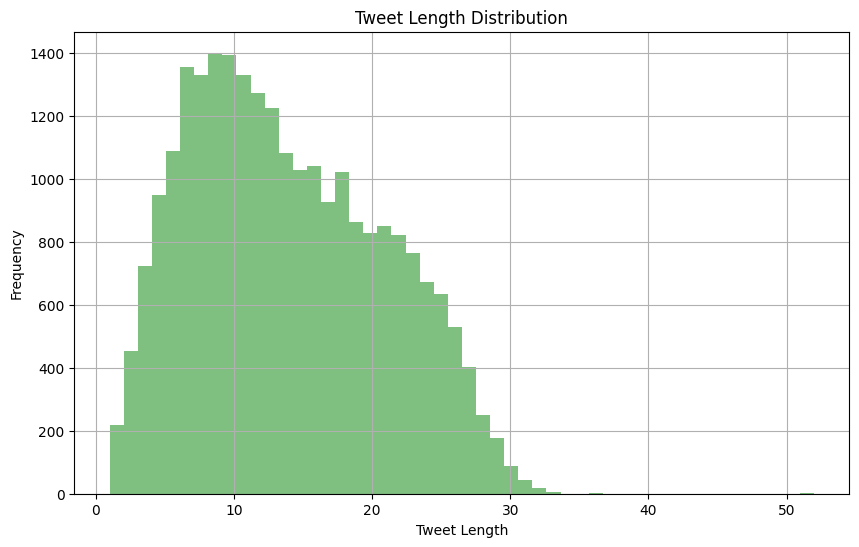

In [18]:
import matplotlib.pyplot as plt

# Calculate length of each tweet in words
df['tweet_length'] = df['tweet'].str.split().str.len()

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(df['tweet_length'], bins=50, alpha=0.5, color='g')
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [19]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet_length
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,25
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,16
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,21
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,9
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,26


In [20]:
# # Calculate the 95th percentile
percentile_95 = np.percentile(df['tweet_length'], 95)

print(f'95th percentile of tweet length: {percentile_95}')

95th percentile of tweet length: 26.0


# Workaround Area

## Merging 2 Datasets

In [7]:
import pandas as pd

# Creating DataFrame 1
df1 = pd.DataFrame({'ID': [1, 2, 3, 4],
                    'value': ['A', 'B', 'C', 'D']})

# Creating DataFrame 2
df2 = pd.DataFrame({'ID2': [2, 3, 4, 5],
                    'count': [10, 20, 30, 40]})

# Merge the two DataFrames based on the 'ID' column using a left join
merged_df = pd.merge(df1, df2, left_on='ID', right_on="ID2", how='left')

print(merged_df)


   ID value  ID2  count
0   1     A  NaN    NaN
1   2     B  2.0   10.0
2   3     C  3.0   20.0
3   4     D  4.0   30.0


In [8]:
df1

,ID,value
0,1,A
1,2,B
2,3,C
3,4,D


In [9]:
df2

,ID2,count
0,2,10
1,3,20
2,4,30
3,5,40


## Appending to already existing dataset

In [10]:
import pandas as pd

# Sample data for the first CSV file
data1 = {'ID': [1, 2, 3],
         'Value': ['A', 'B', 'C']}
df1 = pd.DataFrame(data1)

# Save the first CSV file
df1.to_csv('sample_data.csv', index=False)

In [11]:
df1

,ID,Value
0,1,A
1,2,B
2,3,C


In [12]:
# Sample data for appending
data2 = {'ID': [4, 5],
         'Value': ['D', 'E']}
df2 = pd.DataFrame(data2)

In [13]:
df2

,ID,Value
0,4,D
1,5,E


In [14]:
# Append the additional sample data to the existing CSV file
df2.to_csv('sample_data.csv', mode='a', header=False, index=False)